# Explaining XGBoost model predictions with SHAP values
## Comparing the SHAP value (and SHAP main effect) for patients that attend a hospital, with the SHAP value (and SHAP main effect) for patients that do not attend a hospital

[Representing categorical features as one-hot encoded features in the model and keeping them separate for their SHAP value]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous two notebooks (03a & 3b_xgb_combined_shap_key_features.ipynb) we looked at SHAP values (and main effect) for the one-hot encoded hosptial features. We looked at the values for patients that attend the hospital, and for those that do not (as we have seen that the hospital has a SHAP value when a patient attend another one, so there is a contribution to the prediction based on *not* attending a hospital). 

Here we combine both 3a & 3b into one notebook, so show the main effect and SHAP values for the two poputaltions (attend, and not).

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values of this fitted model and explore the SHAP values for each of the one-hot encoded hospital features.

## Model and data

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the SHAP values for the hospital one-hot encoded features

## Observations
* SHAP values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 58% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

#import scipy.stats

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create output folders if needed

In [2]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
data_loc = '../data/kfold_5fold/'

In [5]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

For this exercise, train the model using all the data. Join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

Set "ignore_index = True" to reset the index from 0 to (n-1), otherwise get duplicate values in the index

In [6]:
data = pd.concat(test_data, ignore_index=True)

Check the final rows index values run up to the number of rows in the dataframe

In [7]:
data.head(-5)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,1
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,1
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,1
...,...,...,...,...,...,...,...,...,...
88782,57.0,1,18.0,0,4,QWKRA8499D,0,93.0,0
88783,19.0,1,14.0,1,0,SQGXB9559U,0,119.0,1
88784,22.0,1,20.0,1,0,KZKEZ2257Z,0,69.0,1
88785,25.0,1,20.0,1,0,QOAPO4699N,0,54.0,0


## Fit XGBoost model

Fit XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. As increase learning rate value, this increases regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (8 one-hot encoded features were not used in the model - had 0 SHAP value for all instances).

Too low a learning rate results in too ____, too high a learning rate results in too ___.

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate


In [11]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42, learning_rate=0.5)
model.fit(X, y)

[21:34:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [12]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [13]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.874


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [14]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_xgb_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values

filename = f'./output/03a_xgb_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 1.82 s, sys: 96.3 ms, total: 1.91 s
Wall time: 233 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [15]:
shap_values[0]

.values =
array([ 7.04962432e-01,  4.70834434e-01,  9.37760234e-01,  4.88724023e-01,
        3.48922372e-01,  1.90080196e-01, -4.45128560e-01,  6.24495908e-04,
       -5.58784464e-04,  9.94549366e-04, -1.44827543e-04, -4.78777918e-04,
        2.03018426e-03,  1.32616831e-03, -4.62164963e-03, -1.44663296e-04,
       -2.64727464e-03,  1.57258241e-03, -5.47267409e-05,  5.59005048e-03,
       -4.94364649e-03, -2.45308410e-03,  6.91119907e-03,  2.98903068e-03,
       -8.01010709e-03,  1.15073301e-04,  1.01976674e-02,  8.05436866e-06,
       -1.34180160e-03,  7.04234745e-03,  8.45438568e-04, -4.65887540e-04,
       -1.33352196e-02, -6.82451949e-03, -8.29387631e-04, -5.12058055e-03,
       -3.64354905e-03, -1.16270920e-03,  1.54822294e-04, -1.55990687e-03,
        1.06859556e-03,  3.09080351e-03,  1.03797121e-02,  1.74750038e-03,
       -3.29944468e-03,  1.61964737e-03, -7.15182303e-03,  3.09971487e-03,
        4.52662492e-03,  1.35833852e-03,  9.84258251e-04,  2.75278743e-03,
        2.54434

There is one of these for each instance.

In [16]:
shap_values.shape

(88792, 139)

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

Use these values to access the main effect for each of the one-hot encoded hospital features.

In [17]:
%%time

filename = f'./output/03a_xgb_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 0 ns, sys: 3.59 s, total: 3.59 s
Wall time: 7.6 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 88792 instances has a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [18]:
shap_interaction.shape

(88792, 139, 139)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [19]:
shap_interaction[0]

array([[ 6.9311428e-01,  3.5109535e-02, -5.6171417e-04, ...,
         2.1258509e-04, -6.8530644e-05, -8.5086795e-04],
       [ 3.5109580e-02,  3.4838551e-01,  4.9971551e-02, ...,
         0.0000000e+00, -1.5326077e-07,  1.3407553e-06],
       [-5.6150556e-04,  4.9971461e-02,  8.3505976e-01, ...,
        -1.4024938e-04,  1.5478528e-03,  3.5843346e-05],
       ...,
       [ 2.1257997e-04,  0.0000000e+00, -1.4033914e-04, ...,
         3.0400229e-03,  0.0000000e+00,  1.5953556e-06],
       [-6.8545341e-05, -1.4901161e-07,  1.5478432e-03, ...,
         0.0000000e+00, -4.5095785e-03,  0.0000000e+00],
       [-8.5088611e-04,  1.3411045e-06,  3.5852194e-05, ...,
         1.5952392e-06,  0.0000000e+00,  4.1305181e-03]], dtype=float32)

# SHAP main effect for the hospital features 

We've seen in notebook 3a that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features, and that the SHAP value (for the instances that attned the hospital) accounts for 58% of the variance in the hositals thrombolysis rate.

Here we will focus on understanding the SHAP main effect values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the SHAP values data 

Features are in the same order in shap_values as they are in the original dataset.

Use this fact to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns: 
1) contribution from all the hospital features
2) contribution from attending the hospital
3) contribution from not attending the rest

In [20]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)
# Include Stroke team that each instance attended
df_hosp_shap_values["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_values_attended_hospital = []
shap_values_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_values_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_values_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_values_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = shap_values_not_attend_these_hospitals
                   
# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.000624,-0.000559,0.000995,-0.000145,-0.000479,0.002030,0.001326,-0.004622,-0.000145,-0.002647,...,0.000899,0.000333,-0.002109,0.002440,-0.000171,0.003061,TXHRP7672C,-0.128209,-0.052531,-0.075677
1,-0.003044,-0.006914,0.002863,-0.000086,-0.000618,0.001353,0.002746,-0.003653,0.000556,-0.002556,...,0.000174,0.001165,-0.000637,0.003117,-0.002408,0.001963,SQGXB9559U,-0.605491,-0.498364,-0.107127
2,-0.001143,-0.019610,0.004226,-0.000075,-0.000728,0.001596,0.002600,-0.007341,-0.000620,-0.002757,...,-0.000233,0.000457,0.000218,0.003129,-0.001370,0.004762,LFPMM4706C,-1.303135,-1.190989,-0.112146
3,-0.003142,0.000237,0.001320,-0.000005,-0.000479,0.001353,0.002746,-0.005188,-0.000247,-0.002505,...,0.000706,0.001165,-0.002276,0.002574,-0.004369,0.002328,MHMYL4920B,0.674405,0.746649,-0.072244
4,0.000523,-0.004762,0.002777,-0.000145,-0.000479,0.000542,0.002729,-0.005198,-0.000258,-0.001873,...,0.000899,0.000687,-0.002109,0.002328,-0.001387,0.002708,EQZZZ5658G,-0.133660,-0.008904,-0.124756


#### Format the SHAP interaction data 

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns: 
1) contribution from all the hospital features
2) contribution from attending the hospital
3) contribution from not attending the rest

In [21]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]

hosp_shap_main_effects = []
# Use this index list to access the hosptial shap values (as array) in the loop below
for i in range(shap_interaction.shape[0]):
    # Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    hosp_shap_main_effects.append(main_effects[hospital_columns_index])
    
# Put in dataframe with hospital as column title
df_hosp_shap_main_effects = pd.DataFrame(hosp_shap_main_effects, columns = hospital_names)

# Include Stroke team that each instance attended
df_hosp_shap_main_effects["Stroke team"] = X_combined["Stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_main_effects["all_stroke_teams"] = df_hosp_shap_main_effects.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_me_attended_hospital = []
shap_me_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_main_effects.iterrows():

    # Get stroke team attended
    stroke_team = row["Stroke team"]
    
    # Get SHAP value for the stroke team attended
    shap_me_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_me_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_main_effects["attended_stroke_team"] = shap_me_attended_hospital
df_hosp_shap_main_effects["not_attended_stroke_teams"] = shap_me_not_attend_these_hospitals
                   
# View preview
df_hosp_shap_main_effects.head()


,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.001201,-0.010994,0.003772,-0.000236,-0.000516,0.001511,0.002794,-0.004233,-0.000425,-0.002723,...,0.000311,0.000812,-0.001057,0.003040,-0.004510,0.004131,TXHRP7672C,-0.192045,-0.104753,-0.087292
1,0.001817,-0.008547,0.003398,-0.000177,-0.000785,0.001611,0.003012,-0.004515,-0.000503,-0.002588,...,0.000442,0.000734,-0.001323,0.002653,-0.003572,0.005024,SQGXB9559U,-0.660367,-0.574617,-0.085751
2,0.002611,-0.009957,0.003751,-0.000166,-0.000635,0.001732,0.003001,-0.003861,-0.001679,-0.002264,...,0.000306,0.000837,-0.001177,0.002934,-0.003586,0.004676,LFPMM4706C,-1.197422,-1.105975,-0.091447
3,0.001719,-0.010199,0.003087,-0.000096,-0.000516,0.001612,0.003012,-0.003859,-0.000528,-0.002537,...,0.000333,0.000734,-0.001044,0.003054,-0.003611,0.004465,MHMYL4920B,0.849224,0.919308,-0.070084
4,0.001600,-0.009127,0.003285,-0.000236,-0.000516,0.001542,0.002996,-0.003869,-0.000539,-0.002627,...,0.000311,0.000776,-0.001057,0.002845,-0.003145,0.004961,EQZZZ5658G,-0.105809,-0.028928,-0.076882


Boxplot to analyse the range of SHAP main effect values for the one-hot encoded hospital features: attended hosptial, and sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

In [54]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    return()

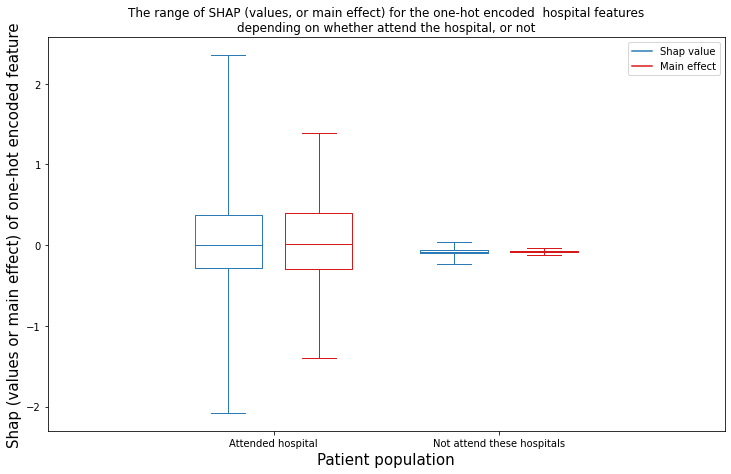

In [50]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ticks = ["Attended hospital", "Not attend these hospitals"]

plot_data_sv = [shap_values_attended_hospital, shap_values_not_attend_these_hospitals]
bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_sv, '#2C7BB6')

plot_data_me = [shap_me_attended_hospital, shap_me_not_attend_these_hospitals]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0+0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_me, '#D7191C') # colors are from http://colorbrewer2.org/

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Shap value')
plt.plot([], c='#D7191C', label='Main effect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

title = ("The range of SHAP (values, or main effect) for the one-hot encoded "
         " hospital features\ndepending on whether attend the hospital, or not")
plt.title(title)
plt.ylabel('Shap (values or main effect) of one-hot encoded feature',size=15)
plt.xlabel('Patient population',size=15)
#plt.xticks(rotation=90)
plt.show()

Create a boxplot to show the range of SHAP main effect values for each one-hot encoded hospital feature. 

Show the SHAP main effect value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of median SHAP main effect for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly to order the hospitals, create a dataframe containing the median SHAP value for each hosptial (for those instances that attended the hospital)

In [51]:
# Create list of SHAP main effect values (one per hospital) for those instances
#   that attend the hospital
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []
for h in hospital_names:
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    data_stroke_team = df_hosp_shap_main_effects[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with two columns (hospital and median_shap
df_hosp_me = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_me["shap_min"] = attend_stroketeam_min
df_hosp_me["shap_q1"] = attend_stroketeam_q1
df_hosp_me["shap_median"] = attend_stroketeam_median
df_hosp_me["shap_q3"] = attend_stroketeam_q3
df_hosp_me["shap_max"] = attend_stroketeam_max

# sort in descending SHAP main effect value order
df_hosp_me.sort_values("shap_median", ascending=False, inplace=True)                
df_hosp_me.head(5)

,hospital,shap_min,shap_q1,shap_median,shap_q3,shap_max
9,CNBGF2713O,0.961615,1.076589,1.130494,1.167219,1.355573
25,GKONI0110I,0.742977,0.982735,1.051632,1.134989,1.360788
32,HPWIF9956L,0.842229,0.982865,1.036947,1.084533,1.264853
109,VKKDD9172T,0.558505,0.959588,1.012563,1.077372,1.342864
65,NTPQZ0829K,0.767124,0.962494,1.003501,1.047912,1.253277


In [52]:
# Create list of SHAP main effect values (one per hospital) for those instances
#   that attend the hospital
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []
for h in hospital_names:
    mask = df_hosp_shap_values['Stroke team'] == h
    data_stroke_team = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with two columns (hospital and median_shap
df_hosp_sv = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_sv["shap_min"] = attend_stroketeam_min
df_hosp_sv["shap_q1"] = attend_stroketeam_q1
df_hosp_sv["shap_median"] = attend_stroketeam_median
df_hosp_sv["shap_q3"] = attend_stroketeam_q3
df_hosp_sv["shap_max"] = attend_stroketeam_max

# sort in descending SHAP main effect value order
df_hosp_sv.sort_values("shap_median", ascending=False, inplace=True)                
df_hosp_sv.head(5)

,hospital,shap_min,shap_q1,shap_median,shap_q3,shap_max
25,GKONI0110I,0.175994,0.934903,1.147333,1.314293,2.120272
9,CNBGF2713O,0.185519,0.871191,1.145275,1.337732,2.030359
109,VKKDD9172T,0.100659,0.741192,0.982388,1.186568,2.090144
65,NTPQZ0829K,0.081631,0.679469,0.935364,1.119871,1.802614
32,HPWIF9956L,0.019245,0.602708,0.908798,1.288176,1.735104


CODE BELOW TO HELP PLOT ADMISSION FIGURES ON HOSPITAL LABEL (LOOK AT THIS CODE IN NOTEBOOK 12C)

# Get SHAP values and data for feature Stroke Team (a categorical feature). Value per instance.
stroketeam_values = shap_values_combined[:,"Stroke team"].values
stroketeam_data = shap_values_combined[:,"Stroke team"].data

# Group data by stroke team.
# Get Stroke team name, the stroke team admission numbers, and list of SHAP values for each instance that attended teh stroke team
stroketeam_categories = list(set(stroketeam_data))
admissions = [X[f'team_{o}'].sum() for o in stroketeam_categories]
stroketeam_groups = [stroketeam_values[stroketeam_data == o] for o in stroketeam_categories]

# Determine order of boxplots by admission values (highest to lowest)
rank_order_admissions = ss.rankdata(admissions)

# Initialise lists
# Populate with the data for the Stroke teams, put in order of admissions, from lowest to highest
stroketeam_groups1 = []
stroketeam_admissions1 = []
stroketeam1 = []
xlabel = []

prev = 99
for j in np.sort(rank_order_admissions):
    if j != prev:
        index1 = np.where(rank_order_admissions == j)
        for i in index1[0]:
            stroketeam_groups1.append(stroketeam_groups[i])
            stroketeam_admissions1.append(admissions[i])
            stroketeam1.append(stroketeam_categories[i])
            xlabel.append(f'{stroketeam_categories[i]} ({admissions[i]})')
    prev = j

# Create boxplots with 35 stroke teams in each
print("(Admission numbers brackets)")
st = 0
ed = 35
inc = ed
max_size = len(stroketeam_groups1)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))
    plt.boxplot(stroketeam_groups1[st:ed],labels=xlabel[st:ed],whis=100)
    plt.ylabel('Shap values',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Create data for boxplot

In [55]:
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = []

hospital_order = df_hosp_me["hospital"]
# Go through to order of hospital in
#1) main effect order
#for h in df_hosp_me["hospital"]:
#2) shap value order
#for h in df_hosp_sv["hospital"]:
#3) admissions order
#for h in df_hosp_me["hospital"]:
#4) thrombolysis order
#for h in df_hosp_me["hospital"]:

for h in hospital_order:
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    me_attend_stroketeam_groups_ordered.append(df_hosp_shap_main_effects[h][mask])
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   do not attend stroke team
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
for h in hospital_order:
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    me_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_main_effects[h][mask])
    sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hosptial


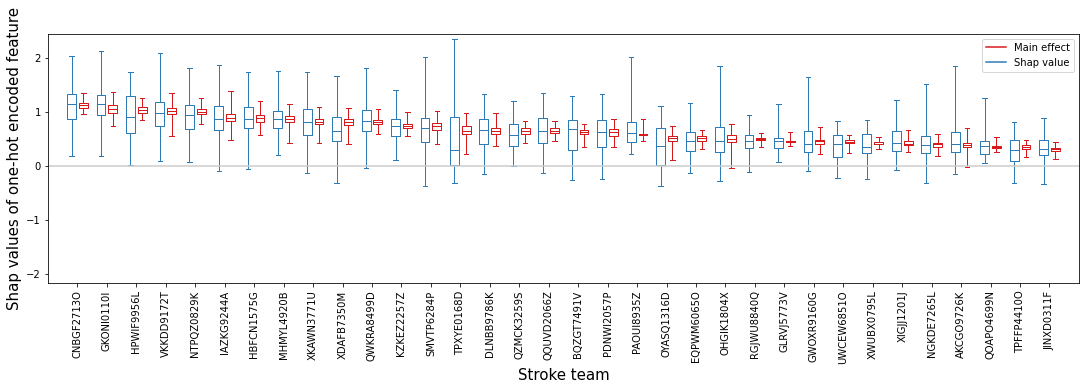

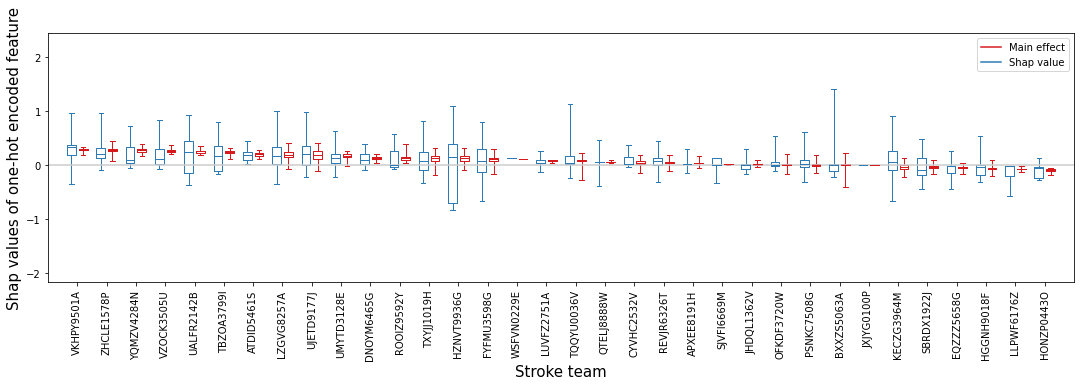

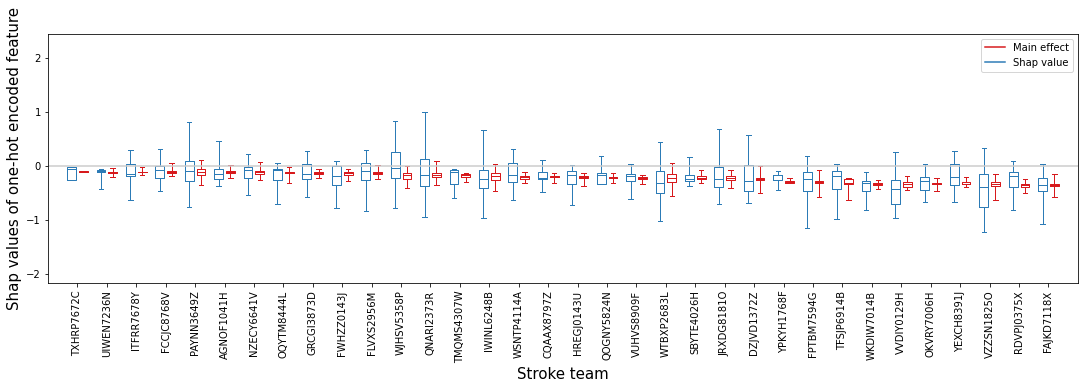

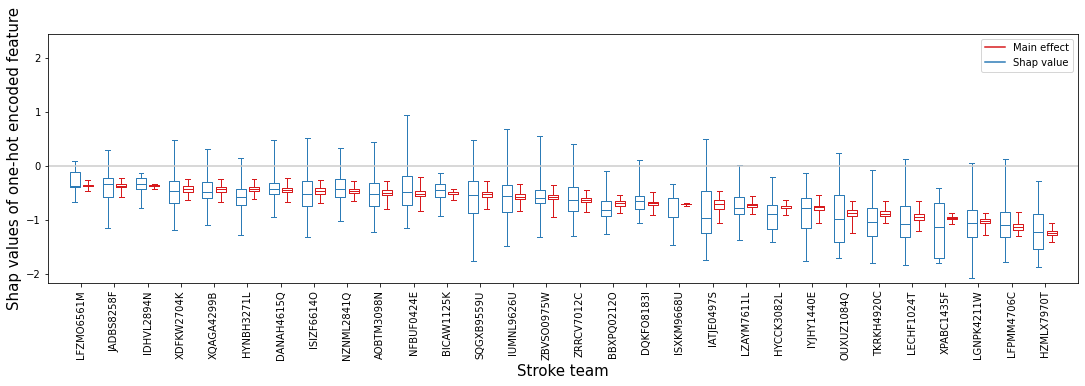

In [76]:
# Plot 35 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = n_hospitals

# Use overall y min and max of both datasets on the 4 plts so have a unified scale
#https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

yrange = ymax - ymin

ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create four plots
for i in range(4):

    # Create figure
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(1,1,1)
    # "The contribution from this hospital when patients do not attend this hosptial"
    
    ticks = hospital_order[st:ed]
    
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.4
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                      positions=pos_sv, 
                      sym='', whis=99999, widths=0.6)
    
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.4
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                      positions=pos_me, 
                      sym='', whis=99999, widths=0.6)
    
    set_box_color(bp_me, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp_sv, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Main effect')
    plt.plot([], c='#2C7BB6', label='Shap value')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)


Notice that when patients do not attend the hospital the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely one side of zero or the other (only a minority of hospitals have their interquartile range spanning zero).

In [77]:
def count_hospitals_in_(hosp_data):
    
    n_iqr_below_zero = hosp_data["shap_q3"] < 0
    n_iqr_spans_zero = hosp_data["shap_q1"] * hosp_data["shap_q3"]
    n_iqr_above_zero = hosp_data["shap_q1"] > 0
    # code below needs improving. This could =0 if -1*q1 = q3
    n_iqr_is_zero = (hosp_data["shap_q1"] + hosp_data["shap_q3"]) == 0
    
    return(n_iqr_below_zero, n_iqr_spans_zero, n_iqr_above_zero, n_iqr_is_zero)

In [78]:
(n_iqr_below_zero_me, n_iqr_spans_zero_me, n_iqr_above_zero_me, n_iqr_is_zero_me) = count_hospitals_in_(df_hosp_me)
(n_iqr_below_zero_sv, n_iqr_spans_zero_sv, n_iqr_above_zero_sv, n_iqr_is_zero_sv) = count_hospitals_in_(df_hosp_sv)

print (f"Number hospitals whose interquartile range is below zero. Main effect: {n_iqr_below_zero_me.sum()}. Shap values: {n_iqr_below_zero_sv.sum()}")
print (f"Number hospitals whose interquartile range spans zero. Main effect: {n_iqr_spans_zero_me.lt(0).sum()}. Shap values: {n_iqr_spans_zero_sv.lt(0).sum()}")
print (f"Number hospitals whose interquartile range is above zero. Main effect: {n_iqr_above_zero_me.sum()}. Shap values: {n_iqr_above_zero_sv.sum()}")
print (f"Number hospitals whose interquartile range is zero. Main effect: {n_iqr_is_zero_me.sum()}. Shap values: {n_iqr_is_zero_sv.sum()}")

Number hospitals whose interquartile range is below zero. Main effect: 69. Shap values: 59
Number hospitals whose interquartile range spans zero. Main effect: 4. Shap values: 21
Number hospitals whose interquartile range is above zero. Main effect: 58. Shap values: 51
Number hospitals whose interquartile range is zero. Main effect: 1. Shap values: 1


How does the SHAP value for the one-hot encoded hospital features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [82]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]

# Join IVT rate with median SHAP value per hosptial
df_hosp_plot = df_hosp_sv[["shap_median","hospital"]].copy(deep=True)
df_hosp_plot.rename(columns={'shap_median':'shap_value_median'}, inplace=True)
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)

# Join IVT rate with median SHAP main effect per hosptial
temp = df_hosp_me[["shap_median","hospital"]].copy(deep=True)
temp.rename(columns={'shap_median':'shap_main_effect_median'}, inplace=True)
temp.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(temp)

# ADD ADMISSIONS
#df_hosp_plot

Plot SHAP value for one-hot encoded hospital feature (median for those instances that attend the hospital) vs hospital IVT rate

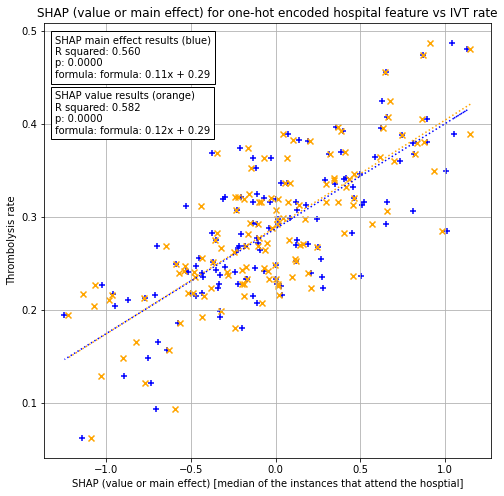

In [83]:
# Setup data for chart
x1 = df_hosp_plot['shap_main_effect_median']
x2 = df_hosp_plot['shap_value_median']
y = df_hosp_plot['Thrombolysis']

# Fit a regression line to the x1 points
slope1, intercept1, r_value1, p_value1, std_err1 = \
    stats.linregress(x1, y)
r_square1 = r_value1 ** 2
y_pred1 = intercept1 + (x1 * slope1)

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y, color = "blue", marker="+")
ax.scatter(x2, y, color = "orange", marker="x")

ax.plot (x1, y_pred1, color = 'blue', linestyle=':')
f1 = 'formula: ' + str("{:.2f}".format(slope1)) + 'x + ' + str("{:.2f}".format(intercept1))
text1 = f'SHAP main effect results (blue)\nR squared: {r_square1:.3f}\np: {p_value1:0.4f}\nformula: {f1}'
ax.text(-1.3, 0.45, text1, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.plot (x2, y_pred2, color = 'orange', linestyle=':')
f2 = 'formula: ' + str("{:.2f}".format(slope2)) + 'x + ' + str("{:.2f}".format(intercept2))
text2 = f'SHAP value results (orange)\nR squared: {r_square2:.3f}\np: {p_value2:0.4f}\nformula: {f2}'
ax.text(-1.3, 0.39, text2, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.set_xlabel("SHAP (value or main effect) [median of the instances that attend the hosptial]")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP (value or main effect) for one-hot encoded hospital feature vs IVT rate")
plt.grid()

plt.show()

### Observations
* SHAP main effect values for the one-hot encoded hospital features are very dependent on whether the instance attended the hospital or not
* SHAP main effect values for the attended one-hot encoded hospital feature are largely one side of zero or the other. There are fewer instances in this population, but the range of SHAP values is wider.
* SHAP main effect values for the not attended one-hot encoded hospitals are largely centred on zero. There are more instances in this population, but the range of SHAP values is narrower.
* 56% of the variability in hospital thrombolysis rate can be explained by the SHAP value for the one-hot encoded hospital feature (the median of those instances that attend the hospital).